## Data Mining Cup 2014

### Import Library

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, glob

Data historis berisi data pembelian dan pengiriman toko online 2014.

##### Atribut
- orderItemID: Nomor barang pesanan
- orderDate: Tanggal pemesanan
- deliveryDate : Tanggal pesanan dikirim
- itemID: ID barang
- size: Ukuran barang
- color: Warna barang
- manufacturerID: ID manufaktur/pabrik
- price: Harga barang
- customerID: ID pelanggan
- salutation: Salutation pelanggan
- dateOfBirth: Tanggal lahir pelanggan
- state: Negara pelanggan
- creationDate: Tanggal pembuatan akun

##### Atribut Keluaran
- returnShipment: Pengembalian (1=ya/dikembalikan, 0=tidak/disimpan)
  - Memprediksi apakah ada pengembalian barang pada pembelian berdasarkan data pembelian baru toko tersebut. Atribut target "returnShipment" dari item pesanan. Nilai "0" berarti "barang disimpan" dan nilai "1" berarti "barang dikembalikan".

In [2]:
#upload file
from google.colab import files
data_to_load = files.upload()

Saving dmc2010_train.txt to dmc2010_train.txt


In [3]:
#load dataset
df = pd.read_csv('orders_train.txt', sep=';', na_values=["?"])

### Eksplorasi Data

In [4]:
#Menampilkan dimensi dataset
df.shape

(481092, 14)

In [5]:
#Menampilkan dataset
df.head()

,orderItemID,orderDate,deliveryDate,itemID,size,color,manufacturerID,price,customerID,salutation,dateOfBirth,state,creationDate,returnShipment
0,1,2012-04-01,2012-04-03,186,m,denim,25,69.90,794,Mrs,1965-01-06,Baden-Wuerttemberg,2011-04-25,0
1,2,2012-04-01,2012-04-03,71,9+,ocher,21,69.95,794,Mrs,1965-01-06,Baden-Wuerttemberg,2011-04-25,1
2,3,2012-04-01,2012-04-03,71,9+,curry,21,69.95,794,Mrs,1965-01-06,Baden-Wuerttemberg,2011-04-25,1
3,4,2012-04-02,NaN,22,m,green,14,39.90,808,Mrs,1959-11-09,Saxony,2012-01-04,0
4,5,2012-04-02,1990-12-31,151,39,black,53,29.90,825,Mrs,1964-07-11,Rhineland-Palatinate,2011-02-16,0


In [6]:
#Menampilkan atribut dan tipe data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 481092 entries, 0 to 481091
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   orderItemID     481092 non-null  int64  
 1   orderDate       481092 non-null  object 
 2   deliveryDate    441673 non-null  object 
 3   itemID          481092 non-null  int64  
 4   size            481092 non-null  object 
 5   color           480949 non-null  object 
 6   manufacturerID  481092 non-null  int64  
 7   price           481092 non-null  float64
 8   customerID      481092 non-null  int64  
 9   salutation      481092 non-null  object 
 10  dateOfBirth     432203 non-null  object 
 11  state           481092 non-null  object 
 12  creationDate    481092 non-null  object 
 13  returnShipment  481092 non-null  int64  
dtypes: float64(1), int64(5), object(8)
memory usage: 51.4+ MB


*Dari detail info di atas terdapat 481092 data entri dengan 14 atribut 6 tipe data numerical dan 8 object.*

In [7]:
#cek data kosong
df.isnull().sum()

orderItemID           0
orderDate             0
deliveryDate      39419
itemID                0
size                  0
color               143
manufacturerID        0
price                 0
customerID            0
salutation            0
dateOfBirth       48889
state                 0
creationDate          0
returnShipment        0
dtype: int64

*Terdapat 3 atribut yang memiliki data kosong yaitu atribut deliveryDate, color, dan dateOfBirth*

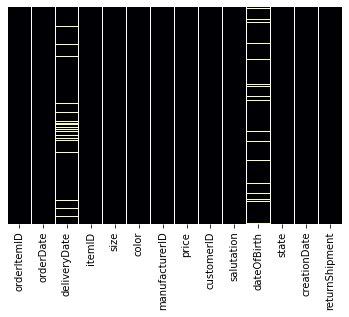

In [8]:
#visualisasi data kosong
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='inferno')

In [9]:
#melihat persentase data kosong
df_na = [a for a in df.columns if df[a].isna().sum()>0]
for a in df_na:
    print(a, np.round(df[a].isna().mean()*100,4), '%')

deliveryDate 8.1937 %
color 0.0297 %
dateOfBirth 10.1621 %


*Dari pengecekan data kosong di atas, data tanggal lahir (dateOfBirth) paling banyak memiliki data kosong sebanyak 48889 atau 10%, kemudian diikuti oleh data tanggal pengiriman (deliveryDate) dan data color.*

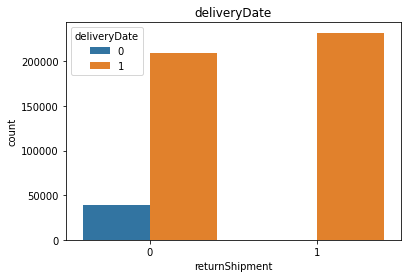

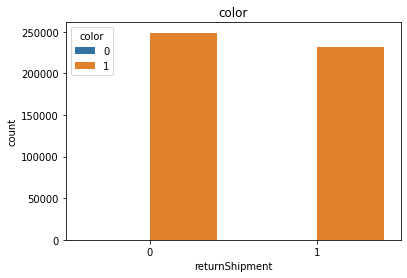

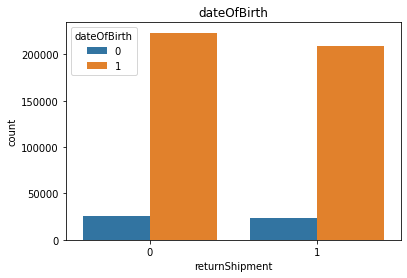

In [10]:
#visualisasi perngaruh nilai/data kosong terhadap data returnShipemnt(pengembalian atau tidak)
data = df.copy()
for a in df_na:
    data_na = data.copy()
    data_na[a] = np.where(data_na[a].isna(),0,1)
    sns.countplot(x='returnShipment',hue = a ,data = data_na)
    plt.title(a)
    plt.show()

*Visualisasi di atas menunjukan bahwa atribut returnShipment memiliki value terhadap data kosong yang dapat menunjukan bahwa atribut returnShipent dapat dipengaruhi oleh atribut-atribut tersebut.*

### Menangani Data Kosong

*3 atribut yang memiliki data kosong yaitu atribut deliveryDate, color, dan dateOfBirth. Penanganan data kosong pada atribut color diisi dengan color yang paling banyak digunakan atau menggunakan modus. Pada atribut deliveryDate dan dateOfBirth karena tipe data 2 atribut tersebut object, maka sebelum penanganan data kosong melakukan konversi tipe data terlebih dahulu dari tipe object ke tipe datetime. Kemudian untuk penanganan data kosongnya dengan melihat terlebih dahulu data tanggal tertinggi (terakhir) dan terendah (terawal). Untuk atribut deliveryDate diisi dengan data tertinggi (max) sedangkan atribut dateOfBirth diisi dengan data terendah (min).*

In [11]:
#Menangani data kosong pada atribut color
#Isi data kosong atribut color dengan warna yang paling banyak digunakan (menggunakan modus)
df.color.fillna(df.color.mode()[0], inplace=True)

In [12]:
#cek data kosong kembali
df.isnull().sum()

orderItemID           0
orderDate             0
deliveryDate      39419
itemID                0
size                  0
color                 0
manufacturerID        0
price                 0
customerID            0
salutation            0
dateOfBirth       48889
state                 0
creationDate          0
returnShipment        0
dtype: int64

*Data color sudah terisi.*

In [13]:
#Mengubah tipe data deliveryDate dan dateOfBirth dari tipe data objek ke tipe datatime
#Mambahkan parameter errors untuk mengabaikan out-of-bound

#Konversi data deliveryDate objek menjadi datetime
df["deliveryDate"] = pd.to_datetime(df["deliveryDate"], format='%Y-%m-%d', errors = 'coerce')

#Konversi data dateOfBirth objek menjadi datetime64
df["dateOfBirth"] = pd.to_datetime(df["dateOfBirth"], format='%Y-%m-%d', errors = 'coerce')

In [14]:
#Cek tipe data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 481092 entries, 0 to 481091
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   orderItemID     481092 non-null  int64         
 1   orderDate       481092 non-null  object        
 2   deliveryDate    441673 non-null  datetime64[ns]
 3   itemID          481092 non-null  int64         
 4   size            481092 non-null  object        
 5   color           481092 non-null  object        
 6   manufacturerID  481092 non-null  int64         
 7   price           481092 non-null  float64       
 8   customerID      481092 non-null  int64         
 9   salutation      481092 non-null  object        
 10  dateOfBirth     432200 non-null  datetime64[ns]
 11  state           481092 non-null  object        
 12  creationDate    481092 non-null  object        
 13  returnShipment  481092 non-null  int64         
dtypes: datetime64[ns](2), float64(1), in

*Tipe data deliveryDate dan dateOfBirth sudah berubah menjadi tipe data datetime*

In [15]:
#Melihat nilai maks dan min tanggal pada atribut deliveryDate dan dateOfBirth yang masih memiliki nilai null
print("Tanggal Maks deliveryDate :", df.deliveryDate.max(), "| Tanggal Min deliveryDate :", df.deliveryDate.min())
print("Tanggal Maks dateOfBirth :", df.dateOfBirth.max(), "| Tanggal Min dateOfBirth :", df.dateOfBirth.min())

Tanggal Maks deliveryDate : 2013-07-22 00:00:00 | Tanggal Min deliveryDate : 1990-12-31 00:00:00
Tanggal Maks dateOfBirth : 2013-06-27 00:00:00 | Tanggal Min dateOfBirth : 1900-11-19 00:00:00


In [16]:
#Mengisi data kosong deliveryDate dengan nilai maks pada data deliveryDate
df["deliveryDate"].fillna(pd.Timestamp('20130722'), inplace=True)

#Mengisi data kosong dateofbirth dengan awal tanggal dan bulan tahun minimal pada data dateofbirth
df["dateOfBirth"].fillna(pd.Timestamp('19000101'), inplace=True)

*Karena tanggal/tahun terendah pada data deliveryDate 1990 maka untuk mengisi data kosong menggunakan tanggal maksimal karena tidak mungkin pesanan dikirim pada tahun tersebut. Sedangkan pada data dateofbirth diisi dengan tanggal minimal karena tidak mungkin yang memesan barang lahir di tahun terakhir/terbaru (2013).*

In [17]:
#cek data kosong lagi
df.isnull().sum()

orderItemID       0
orderDate         0
deliveryDate      0
itemID            0
size              0
color             0
manufacturerID    0
price             0
customerID        0
salutation        0
dateOfBirth       0
state             0
creationDate      0
returnShipment    0
dtype: int64

*Sudah tidak terdapat nilai kosong lagi.*

#### Menangani data yang memiliki arti yang sama tetapi dikenali sebagai data yang berbeda

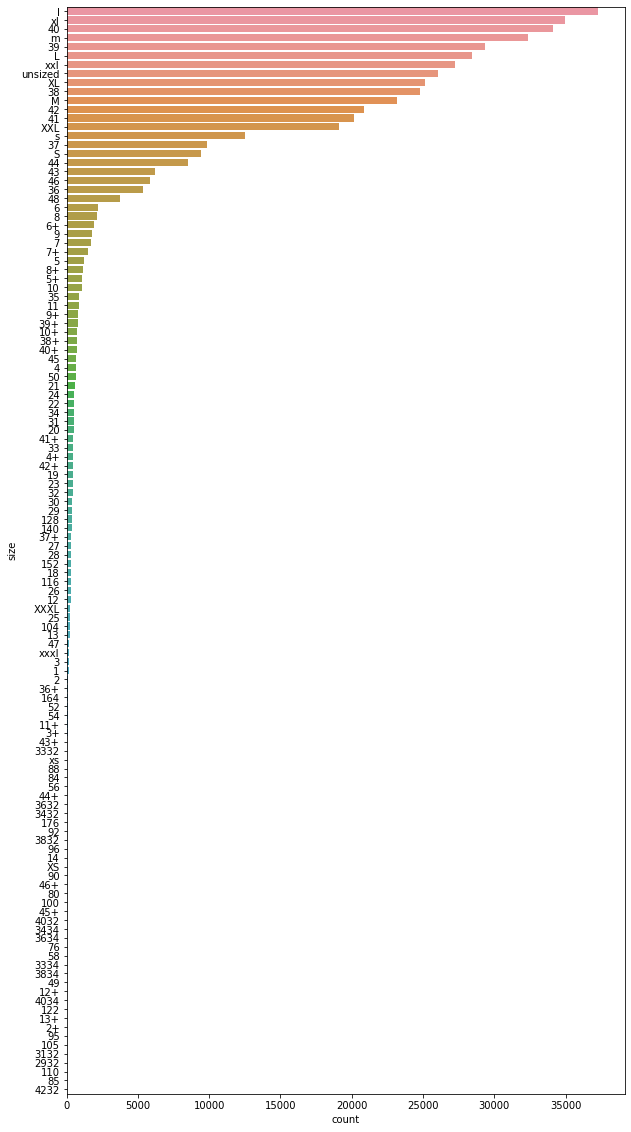

In [18]:
#visualisasi data size
plt.figure(figsize = (10, 20))
sns.countplot(y="size", data=df, order = df["size"].value_counts().index)
plt.show()

*Dari visualisasi atribut 'size' di atas terdapat ukuran yang menggunakan huruf kecil dan huruf kapital misalnya ukuran m dan M yang merupakan jenis ukuran yang sama tetapi dikategorikan berbeda. Untuk mencegah hal tersebut saya mencoba mengubah semua ukuran yang menggunakan huruf kecil dengan huruf kapital agar terhitung sebagai kategori yang sama. Kemudian untuk ukuran yang memiliki karakter "+" akan dihapus, dibulatkan ke angka saja misal ukuran 9+ akan diubah menjadi 9 dengan asumsi hanya memiliki selisih sedikit.*

In [19]:
#Mengubah isi data size yang ukurannya huruf kecil dengan huruf kapital agar terhitung menjadi jenis yang sama.
df['size'] = df['size'].str.upper()

In [20]:
#menghilangkan karakter "+"
df['size'] = df['size'].str.replace('+', '')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  


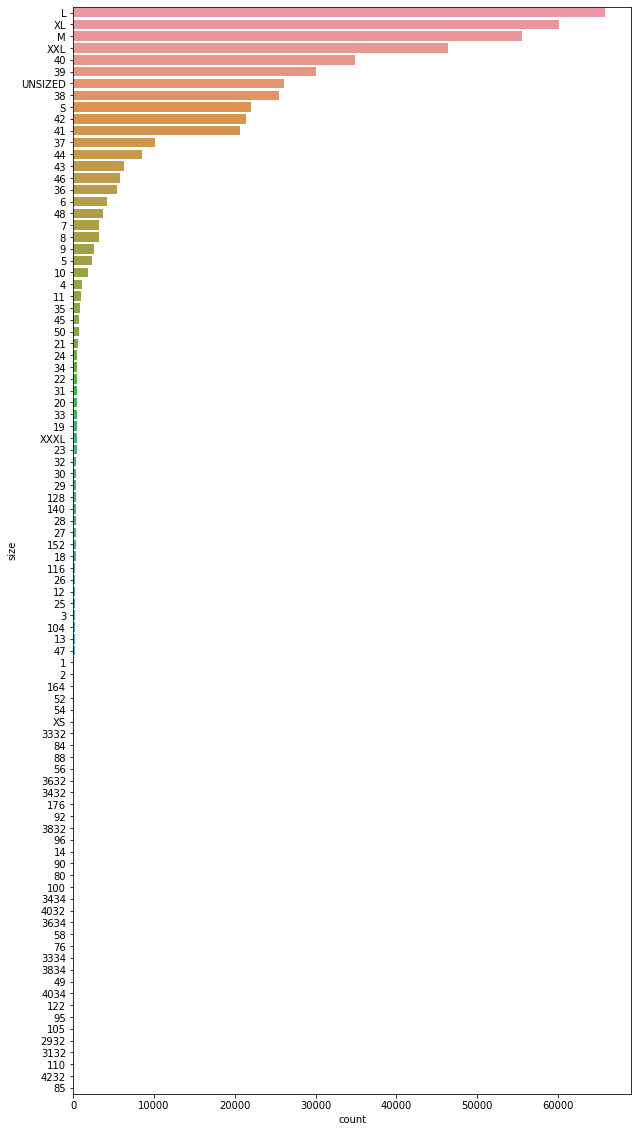

In [21]:
#visualisasi data size setelah diubah
plt.figure(figsize = (10, 20))
sns.countplot(y="size", data=df, order = df["size"].value_counts().index)
plt.show()

*Setelah atribut size ditangani dapat dilihat terdapat perbedaan data size di mana sebelum di tangani urutan 3 data size tertinggi yaitu l, xl dan 40. Setelah ditangani urutan 3 data size tertinggi yaitu L, XL, dan M. Dan terdapat beberapa perbedaan urutan tertinggi lainnya.*

In [22]:
#cek atribut dengan tipe data objek
df_obj= df.select_dtypes(include = ['object'])
df_obj.head()

,orderDate,size,color,salutation,state,creationDate
0,2012-04-01,M,denim,Mrs,Baden-Wuerttemberg,2011-04-25
1,2012-04-01,9,ocher,Mrs,Baden-Wuerttemberg,2011-04-25
2,2012-04-01,9,curry,Mrs,Baden-Wuerttemberg,2011-04-25
3,2012-04-02,M,green,Mrs,Saxony,2012-01-04
4,2012-04-02,39,black,Mrs,Rhineland-Palatinate,2011-02-16


#### Konversi data yang masih bertipe objek

*Mengubah data bertipe objek menjadi data bertipe kategori, jika data objek berformat tanggal diubah menjadi tipe data datetime*

In [23]:
#Konversi data tipe objek menjadi kategori
#Mengubah type data objek selain format tanggal menjadi kategori
kategori = ['size', 'color', 'salutation', 'state']
#Looping untuk merubah type data'
for column in kategori:
    df[column] = df[column].astype('category')

In [24]:
#Mengubah type data objek dengan format tanggal menjadi datetime

#Konversi data atribut orderDate menjadi datetime
df["orderDate"] = df["orderDate"].astype("datetime64[ns]")

#Konversi data atribut creationDate menjadi datetime
df["creationDate"] = df["creationDate"].astype("datetime64[ns]")

In [25]:
#Cek tipe data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 481092 entries, 0 to 481091
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   orderItemID     481092 non-null  int64         
 1   orderDate       481092 non-null  datetime64[ns]
 2   deliveryDate    481092 non-null  datetime64[ns]
 3   itemID          481092 non-null  int64         
 4   size            481092 non-null  category      
 5   color           481092 non-null  category      
 6   manufacturerID  481092 non-null  int64         
 7   price           481092 non-null  float64       
 8   customerID      481092 non-null  int64         
 9   salutation      481092 non-null  category      
 10  dateOfBirth     481092 non-null  datetime64[ns]
 11  state           481092 non-null  category      
 12  creationDate    481092 non-null  datetime64[ns]
 13  returnShipment  481092 non-null  int64         
dtypes: category(4), datetime64[ns](4), f

### Menangani Outlier

In [26]:
df[['price']].describe()

,price
count,481092.000000
mean,70.440229
std,45.502854
min,0.000000
25%,34.900000
50%,59.900000
75%,89.900000
max,999.000000


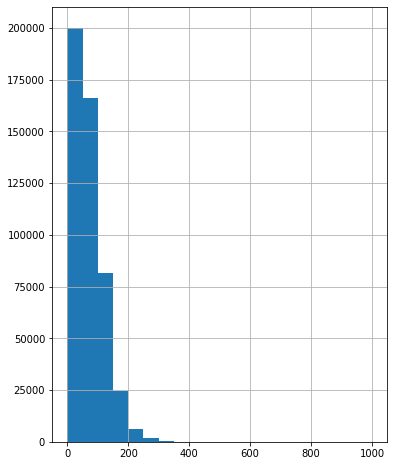

In [27]:
#Distribusi data price
df['price'].hist(bins=20, figsize=(6, 8))
plt.show()

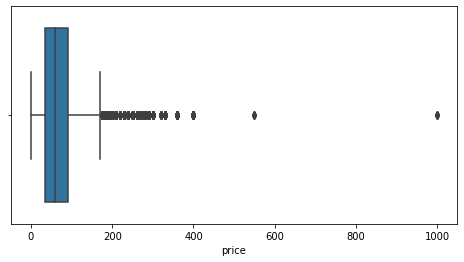

In [28]:
#visualisasi outlier pada data price
plt.figure(figsize = (8, 4))
sns.boxplot(x = df.price)

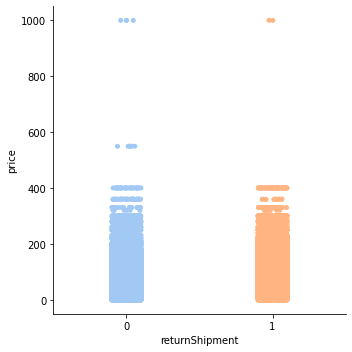

In [29]:
#visualisasi price dengan returnShipment
sns.catplot(x='returnShipment', y='price', hue = 'returnShipment', data = df, palette='pastel')

In [30]:
#menghitung 0.999 persentile dari atribut price
max_price = df.price.quantile(0.999)
max_price

299.9

In [31]:
#remove data outlier
df = df[(df.price<max_price)]

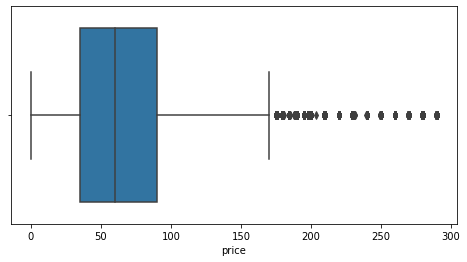

In [32]:
#visualisasi setelah dilakukan penghapusan outlier
plt.figure(figsize = (8, 4))
sns.boxplot(x = df.price)

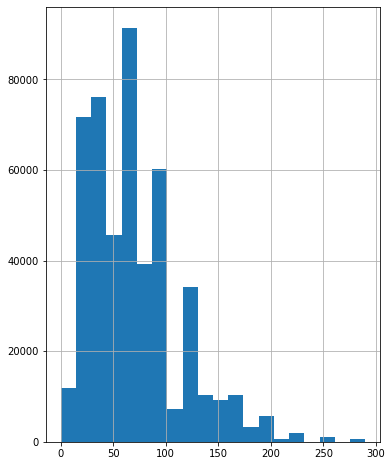

In [33]:
#Distribusi data price setelah penanganan outlier
df['price'].hist(bins=20, figsize=(6, 8))
plt.show()

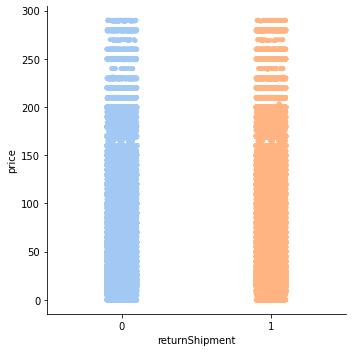

In [34]:
#visualisasi setelah dilakukan penghapusan outlier atribut price dengan returnShipment
sns.catplot(x='returnShipment', y='price', hue = 'returnShipment', data = df, palette='pastel')

### Visualisasi Data

In [35]:
#Cek jumlah data pada returnShipment untuk melihat apakah data target "returShipment" imbalance atau tidak
shipment = len(df.returnShipment)
disimpan_count = len(df[df.returnShipment == 0])
dikembalikan_count = len(df[df.returnShipment == 1])
disimpan_percentage = round(disimpan_count/shipment*100, 2)
dikembalikan_percentage = round(dikembalikan_count/shipment*100, 2)

print('Total shipment {}'.format(shipment))
print('Barang tidak dikembalikan {}'.format(disimpan_count))
print('Barang dikembalikan {}'.format(dikembalikan_count))
print('Persentase tidak dikembalikan {}%'.format(disimpan_percentage))
print('Persentase dikembalikan {}%'.format(dikembalikan_percentage))

Total shipment 480358
Barang tidak dikembalikan 248699
Barang dikembalikan 231659
Persentase tidak dikembalikan 51.77%
Persentase dikembalikan 48.23%


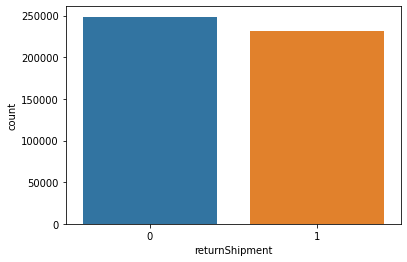

In [36]:
#visualisasi data yang melakukan pengembalian barang dan yang tidak melakukan pengembalian (tetap disimpan)
sns.countplot(x='returnShipment', data = df)

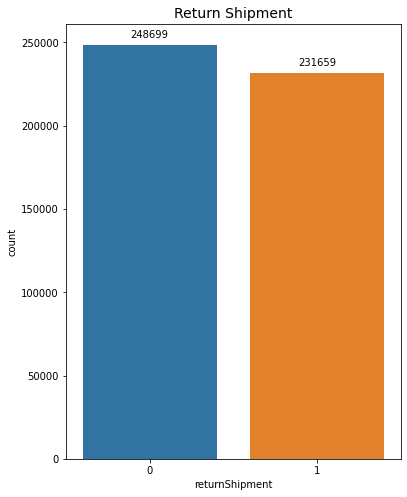

In [37]:
plt.figure(figsize=(6,8))
ax = sns.countplot(x='returnShipment', data = df)
plt.title('Return Shipment', fontsize=14)

for p in ax.patches:
        ax.annotate(format(p.get_height(), 'd'), (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

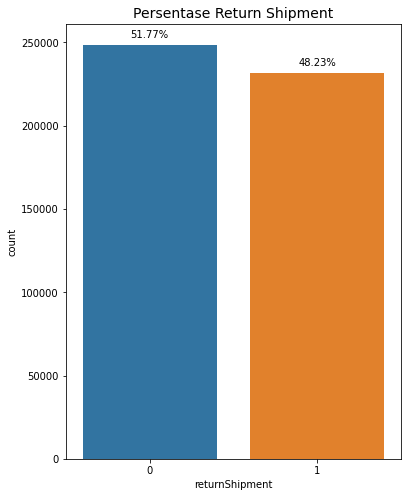

In [38]:
plt.figure(figsize=(6,8))
total = float(len(df))
ax = sns.countplot(x='returnShipment', data=df)
plt.title('Persentase Return Shipment', fontsize=14)

for p in ax.patches:
        ax.annotate(format(100 * p.get_height()/total, '.2f') + '%', (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

*Dari visualisasi-visualisasi terhadap atribut target "returnShipment" di atas, dapat dilihat bahwa antara data yang mengembalikan dengan yang tidak mengembalikan barang cukup seimbang. Dimana yang tidak mengembalikan barang persentasenya lebih tinggi (51,7%) dibandingkan yang mengembalikan barang (48,2%)*

In [39]:
#Melihat banyaknya pesanan tiap salutation
df.groupby("salutation")["salutation"].count()

salutation
Company            361
Family            1886
Mr               16677
Mrs             461084
not reported       350
Name: salutation, dtype: int64

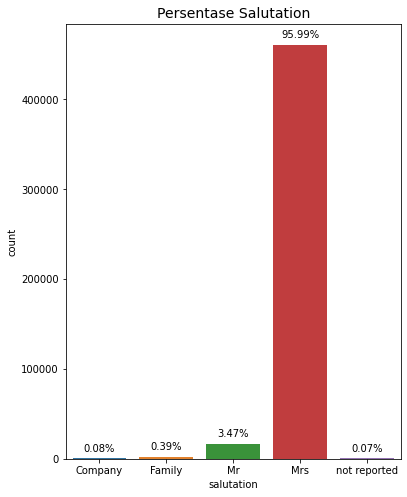

In [40]:
#visualisasi persentase data salutation
plt.figure(figsize=(6,8))
total = float(len(df['salutation']))
ax = sns.countplot(x='salutation', data=df)
plt.title('Persentase Salutation', fontsize=14)

for p in ax.patches:
        ax.annotate(format(100 * p.get_height()/total, '.2f') + '%', (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

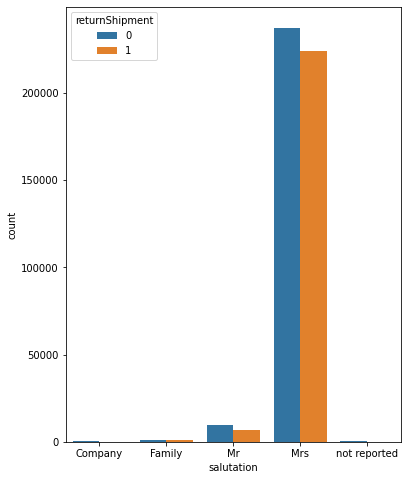

In [41]:
#visualisasi hubungan salutation dengan returnShipment
plt.figure(figsize=(6,8))
sns.countplot(x="salutation", hue = "returnShipment", data=df)

In [42]:
#Melihat banyaknya pesanan tiap salutation yang mengembalikan pesanan dengan yang tidak mengembalikan pesanan
df.groupby(["returnShipment","salutation"])["salutation"].count()

returnShipment  salutation  
0               Company            193
                Family            1056
                Mr                9835
                Mrs             237377
                not reported       238
1               Company            168
                Family             830
                Mr                6842
                Mrs             223707
                not reported       112
Name: salutation, dtype: int64

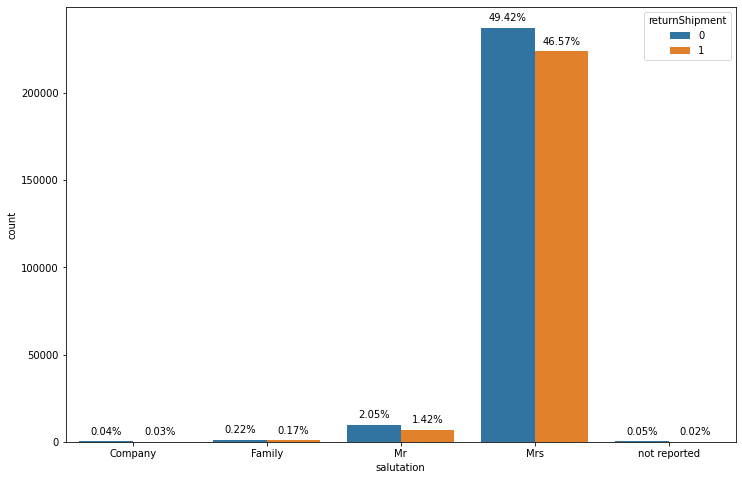

In [43]:
#visualisasi hubungan salutation dengan returnShipment
plt.figure(figsize=(12,8))
total = float(len(df['salutation']))
ax = sns.countplot(x="salutation", hue = "returnShipment", data=df)

for p in ax.patches:
        ax.annotate(format(100 * p.get_height()/total, '.2f') + '%', (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

*Pesanan terbanyak oleh salutation "Mrs" sebanyak 461084 pesanan atau 95.99% dari total pesanan dengan pesanan tidak dikembalikan atau disimpan lebih banyak yaitu 49.2% dibandingkan pesanan dikembalikan yaitu 46.5%*

Text(0.5, 1.0, 'State')

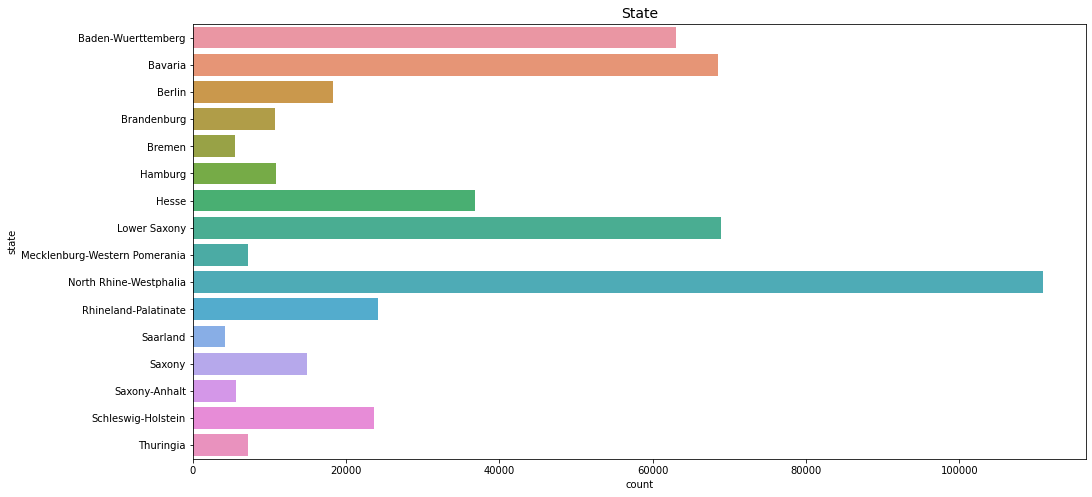

In [44]:
#visualisasi persentase data state
plt.figure(figsize=(16, 8))
total = float(len(df['state']))
sns.countplot(y='state', data=df)
plt.title('State', fontsize=14)

In [45]:
#Melihat jumlah pesanan tiap state
df.groupby("state")["state"].count()

state
Baden-Wuerttemberg                63010
Bavaria                           68544
Berlin                            18275
Brandenburg                       10763
Bremen                             5505
Hamburg                           10839
Hesse                             36777
Lower Saxony                      68915
Mecklenburg-Western Pomerania      7159
North Rhine-Westphalia           110958
Rhineland-Palatinate              24184
Saarland                           4212
Saxony                            14850
Saxony-Anhalt                      5577
Schleswig-Holstein                23626
Thuringia                          7164
Name: state, dtype: int64

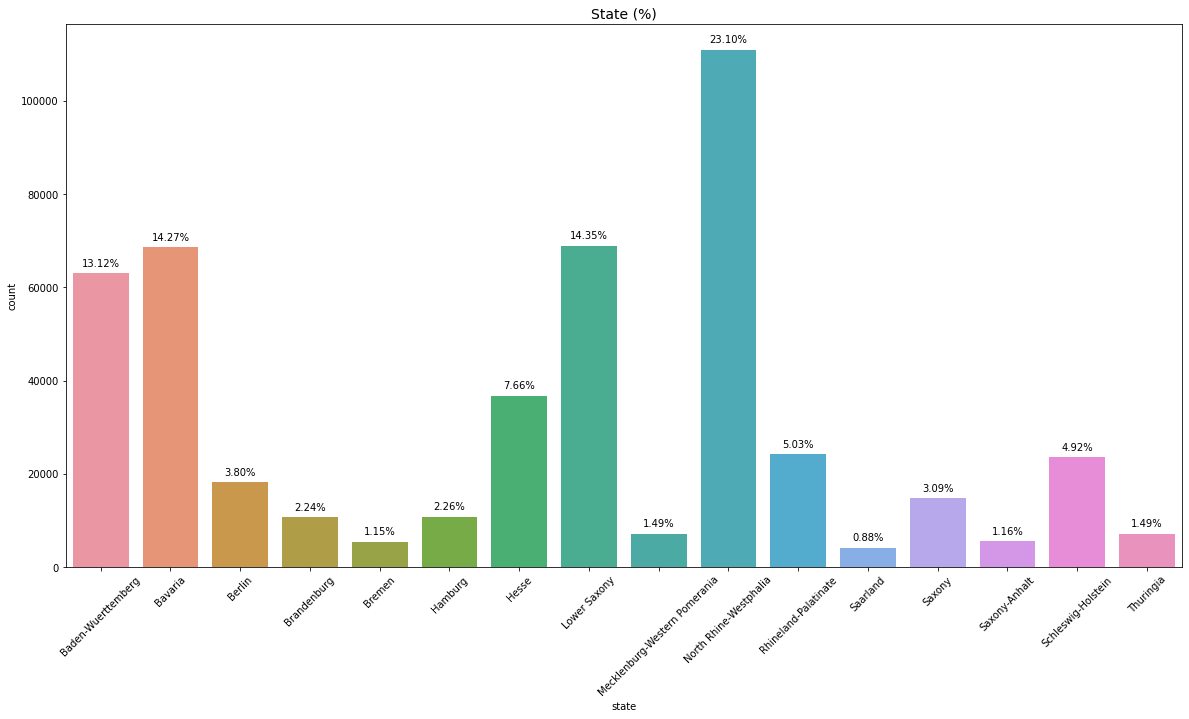

In [46]:
#visualisasi persentase state
plt.figure(figsize=(20, 10))
plt.xticks(rotation=45)
total = float(len(df['state']))
ax = sns.countplot(x='state', data=df)
plt.title('State (%)', fontsize=14)

for p in ax.patches:
        ax.annotate(format(100 * p.get_height()/total, '.2f') + '%', (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

In [47]:
#Melihat jumlah pesanan tiap state yang mengembalikan pesanan dengan yang tidak mengembalikan pesanan
df.groupby(["returnShipment","state"])["state"].count()

returnShipment  state                        
0               Baden-Wuerttemberg               32662
                Bavaria                          35340
                Berlin                            9702
                Brandenburg                       5363
                Bremen                            3037
                Hamburg                           6026
                Hesse                            18997
                Lower Saxony                     35506
                Mecklenburg-Western Pomerania     3556
                North Rhine-Westphalia           58124
                Rhineland-Palatinate             12345
                Saarland                          2256
                Saxony                            7311
                Saxony-Anhalt                     2748
                Schleswig-Holstein               12162
                Thuringia                         3564
1               Baden-Wuerttemberg               30348
                Bav

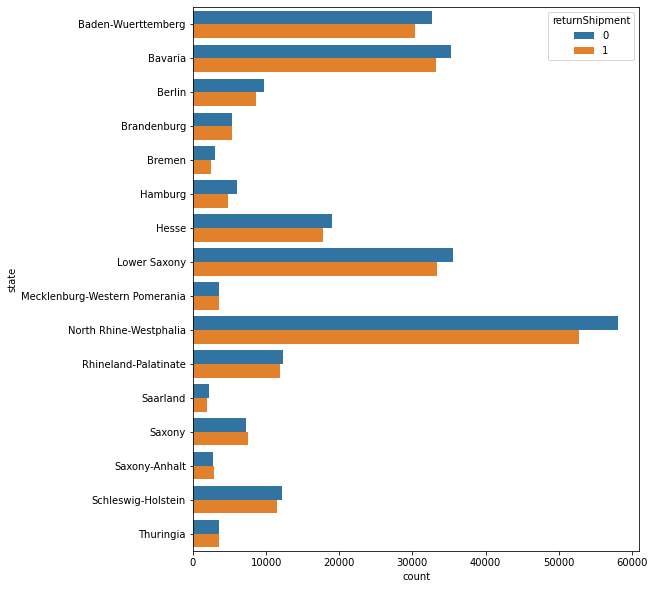

In [48]:
#visualisasi hubungan state dengan returnShipment
plt.figure(figsize=(8,10))
sns.countplot(y="state", hue = "returnShipment", data=df)

*Pesanan terbanyak terdapat pada state "Nort Rhine-Westphalia" sebanyak  110958 pesanan atau 23.10% dari total pesanan dengan pesanan tidak dikembalikan atau disimpan lebih banyak dibandingkan pesanan dikembalikan.*

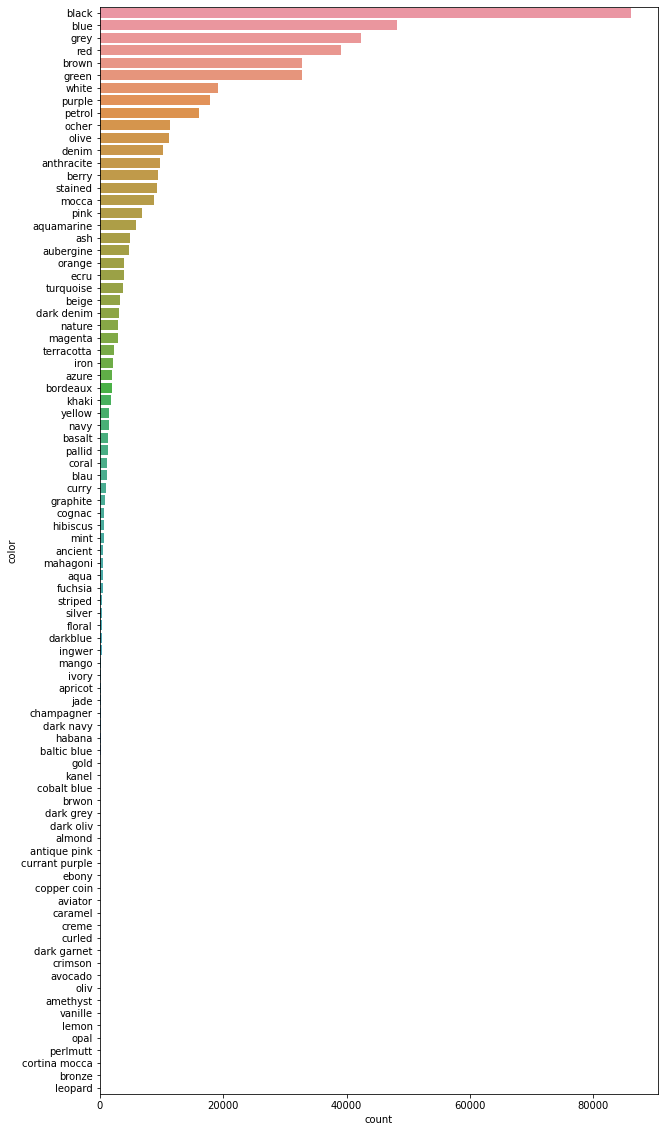

In [49]:
#visualisasi data color
plt.figure(figsize = (10, 20))
sns.countplot(y="color", data=df, order = df["color"].value_counts().index)
plt.show()

*Pesanan terbanyak dengan warna hitam. Ini bisa juga dikarenakan banyak barang-barang yang berwarna hitam.*

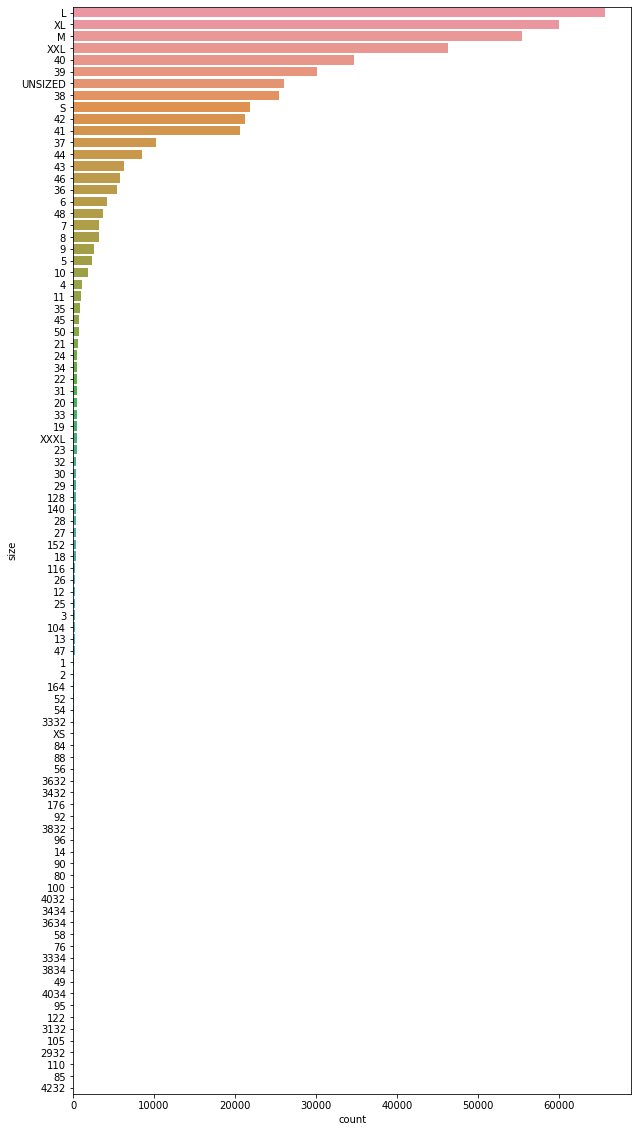

In [50]:
#visualisasi data size
plt.figure(figsize = (10, 20))
sns.countplot(y="size", data=df, order = df["size"].value_counts().index)
plt.show()

*Pesanan dengan size "L" paling banyak dipesan.*

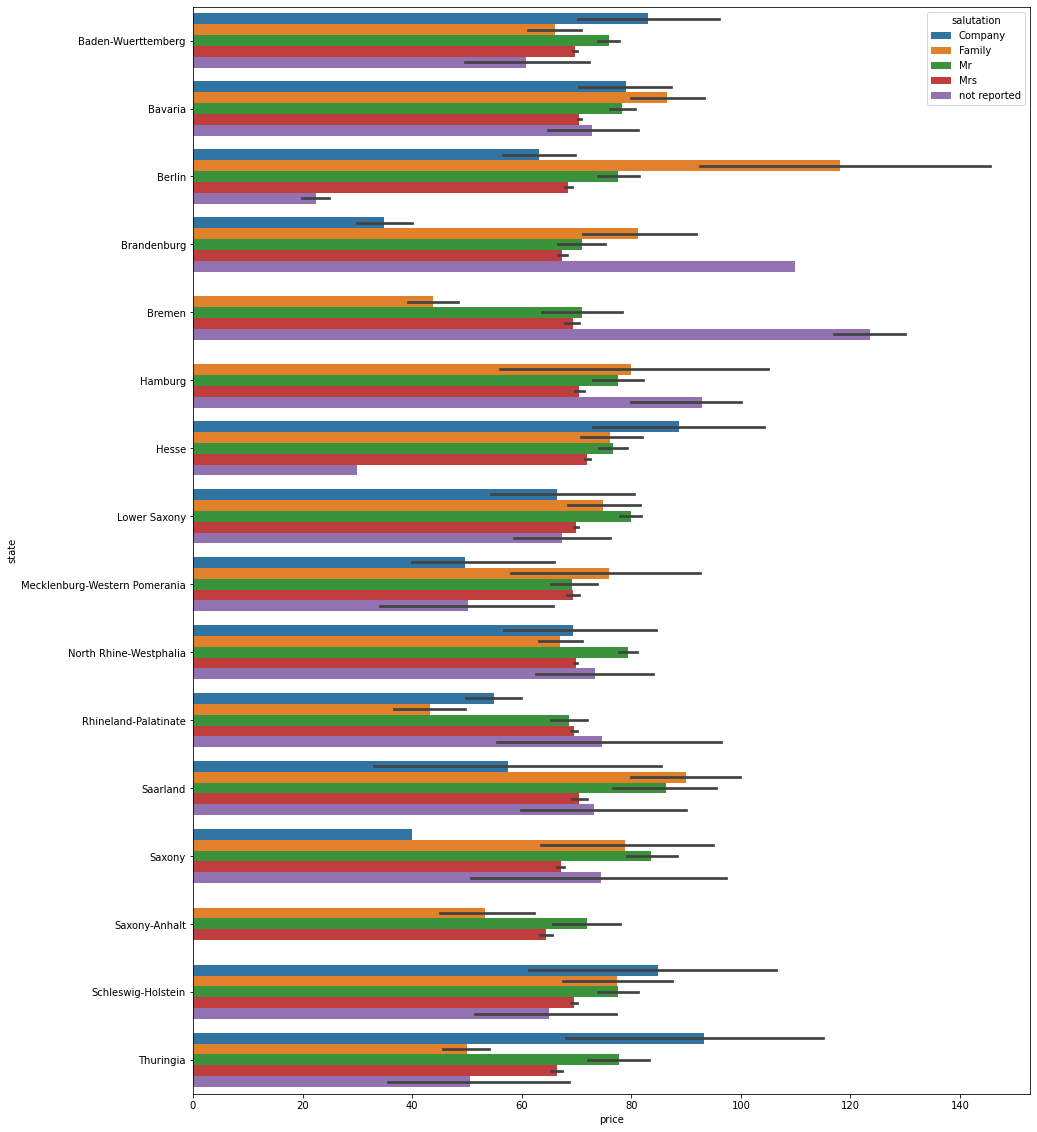

In [51]:
#visualisasi hubungan data price, state, dan salutation
fig, ax = plt.subplots(figsize=(15, 20))
sns.barplot(x='price', y='state', hue='salutation', data=df)

*Dari grafik di atas dapat diketahui state Berlin dan Breman memiliki harga pemesanan tinggi. Tiap state pesanan didominasi pesanan dari salutation yang berbeda-beda.*

### Training

In [52]:
#Salin data df
df_train = df.copy()

In [53]:
#encoding atribut returnShipment menggunakan LabelEncoder
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(df_train.returnShipment)
Y = le.transform(df_train.returnShipment)

In [54]:
#mengaplikasikan one hot encoding untuk data bertipe categorical
df_train=pd.get_dummies(data=df_train, columns=['size', 'color', 'salutation', 'state'])

In [55]:
#cek atribut dan tipe data data train
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 480358 entries, 0 to 481091
Columns: 210 entries, orderItemID to state_Thuringia
dtypes: datetime64[ns](4), float64(1), int64(5), uint8(200)
memory usage: 148.1 MB


In [56]:
#Siapkan atribut training dengan membuang kelas label (kelas label sudah pindah ke variabel Y sebelumnya)
X = df_train.drop("returnShipment", axis=1)

In [57]:
#melihat data train
df_train.head()

,orderItemID,orderDate,deliveryDate,itemID,manufacturerID,price,customerID,dateOfBirth,creationDate,returnShipment,...,state_Hesse,state_Lower Saxony,state_Mecklenburg-Western Pomerania,state_North Rhine-Westphalia,state_Rhineland-Palatinate,state_Saarland,state_Saxony,state_Saxony-Anhalt,state_Schleswig-Holstein,state_Thuringia
0,1,2012-04-01,2012-04-03,186,25,69.90,794,1965-01-06,2011-04-25,0,...,0,0,0,0,0,0,0,0,0,0
1,2,2012-04-01,2012-04-03,71,21,69.95,794,1965-01-06,2011-04-25,1,...,0,0,0,0,0,0,0,0,0,0
2,3,2012-04-01,2012-04-03,71,21,69.95,794,1965-01-06,2011-04-25,1,...,0,0,0,0,0,0,0,0,0,0
3,4,2012-04-02,2013-07-22,22,14,39.90,808,1959-11-09,2012-01-04,0,...,0,0,0,0,0,0,1,0,0,0
4,5,2012-04-02,1990-12-31,151,53,29.90,825,1964-07-11,2011-02-16,0,...,0,0,0,0,1,0,0,0,0,0


In [58]:
#Mengubah data bertipe tanggal untuk keperluan pembelajaran mesin
import datetime as dt
X['orderDate'] = X['orderDate'].map(dt.datetime.toordinal)
X['deliveryDate'] = X['deliveryDate'].map(dt.datetime.toordinal)
X['dateOfBirth'] = X['dateOfBirth'].map(dt.datetime.toordinal)
X['creationDate'] = X['creationDate'].map(dt.datetime.toordinal)

In [59]:
#Split Dataset, 80% sebagai data train dan 20% sisanya sebagai data test
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,random_state=123)

In [60]:
#Simpan nama kolom untuk keperluan prediksi nanti
import pickle
with open('D:\\Eva\\data\\pick14.pickle', 'wb') as fp:
    pickle.dump(X_train.columns, fp)

### Klasifikasi

In [61]:
#Naive Bayes
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
clf = GaussianNB()
clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)
acc = accuracy_score(Y_test, Y_pred)
f1 = f1_score(Y_test, Y_pred)
print("Akurasi {}".format(acc))
print("F1-Score {}".format(f1))
print(classification_report(Y_test, Y_pred))

Akurasi 0.5529810975102006
F1-Score 0.6176936635390888
              precision    recall  f1-score   support

           0       0.61      0.37      0.46     49761
           1       0.53      0.75      0.62     46311

    accuracy                           0.55     96072
   macro avg       0.57      0.56      0.54     96072
weighted avg       0.57      0.55      0.54     96072



In [62]:
#decision tree
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)
acc = accuracy_score(Y_test, Y_pred)
f1 = f1_score(Y_test, Y_pred)
print("Akurasi {}".format(acc))
print("F1-Score {}".format(f1))
print(classification_report(Y_test, Y_pred))

Akurasi 0.6143725539178949
F1-Score 0.6020708470279909
              precision    recall  f1-score   support

           0       0.63      0.62      0.63     49761
           1       0.60      0.61      0.60     46311

    accuracy                           0.61     96072
   macro avg       0.61      0.61      0.61     96072
weighted avg       0.61      0.61      0.61     96072



In [63]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=70, random_state=123)
clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)
acc = accuracy_score(Y_test, Y_pred)
f1 = f1_score(Y_test, Y_pred)
print("Akurasi {}".format(acc))
print("F1-Score {}".format(f1))
print(classification_report(Y_test, Y_pred))

Akurasi 0.6603797152135898
F1-Score 0.6643071731346969
              precision    recall  f1-score   support

           0       0.69      0.63      0.66     49761
           1       0.63      0.70      0.66     46311

    accuracy                           0.66     96072
   macro avg       0.66      0.66      0.66     96072
weighted avg       0.66      0.66      0.66     96072



*Dari metode machine learning di atas, akurasi dan f1-score tertinggi menggunakan random forest yaitu 0.66 dan 0.66. Tertinggi kedua oleh decision tree, terakhir oleh naive bayes.*

In [64]:
#Melihat fitur mana yang paling penting bagi model
feature_importances = pd.DataFrame(clf.feature_importances_,index = X_train.columns,
columns=['importance']).sort_values('importance',ascending=False)
print(feature_importances)

                 importance
deliveryDate   1.486183e-01
orderItemID    9.422652e-02
customerID     8.377358e-02
dateOfBirth    8.287188e-02
orderDate      7.438448e-02
...                     ...
color_bronze   3.547787e-07
color_leopard  3.426724e-07
size_3132      2.348054e-07
size_105       5.157676e-08
size_110       0.000000e+00

[209 rows x 1 columns]


In [65]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(Y_test, Y_pred))

[[31160 18601]
 [14027 32284]]


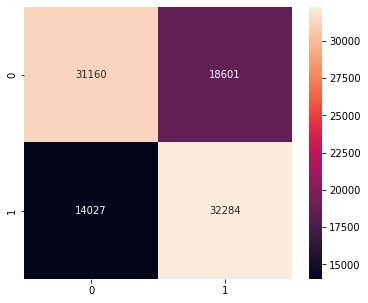

In [66]:
plt.figure(figsize = (6, 5))
sns.heatmap(confusion_matrix(Y_test, Y_pred), annot = True, fmt="d")

In [67]:
#cross validation dengan random forest
from sklearn.metrics import classification_report, accuracy_score, make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
def classification_report_with_score(y_true, y_pred):
    print(classification_report(y_true, y_pred))
    print(confusion_matrix(y_true, y_pred))
    return accuracy_score(y_true, y_pred)

clf = RandomForestClassifier(n_estimators=70, random_state=123)
clf.fit(X_train, Y_train)
scores = cross_val_score(clf, X=X, y=Y, cv=5, 
                         scoring=make_scorer(classification_report_with_score))
print(scores)

              precision    recall  f1-score   support

           0       1.00      0.19      0.32     49740
           1       0.53      1.00      0.70     46332

    accuracy                           0.58     96072
   macro avg       0.77      0.60      0.51     96072
weighted avg       0.78      0.58      0.50     96072

[[ 9475 40265]
 [    9 46323]]
              precision    recall  f1-score   support

           0       0.52      1.00      0.68     49740
           1       0.76      0.00      0.00     46332

    accuracy                           0.52     96072
   macro avg       0.64      0.50      0.34     96072
weighted avg       0.63      0.52      0.35     96072

[[49723    17]
 [46278    54]]
              precision    recall  f1-score   support

           0       0.51      0.54      0.53     49740
           1       0.48      0.45      0.46     46332

    accuracy                           0.50     96072
   macro avg       0.50      0.50      0.49     96072
weighted avg

In [68]:
#simpan model dengan joblib
import joblib as jb
jb.dump(clf, "D:\\Eva\\data\\job14.joblib")

['D:\\Eva\\data\\job14.joblib']

### Prediksi

In [69]:
#load dataset
df2 = pd.read_csv('orders_train.txt', sep=';', na_values=["?"])

In [70]:
#isi data kosong dengan data modus
df2.fillna(df2.color.mode()[0], inplace=True)

In [71]:
#ubah semua kata size jadi kapital
df2['size'] = df2['size'].str.upper()

In [72]:
#hapus karakter + data size 
df2['size'] = df2['size'].str.replace('+', '')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  


In [73]:
#ubah tipe data object menjadi category
cat_col = ["size", "color", "salutation", "state"]
for col in cat_col:
    df2[col] = df2[col].astype("category")

In [74]:
#upload file
from google.colab import files
data_to_load = files.upload()

Saving orders_class.txt to orders_class.txt


In [75]:
#load dataset
df_pred = pd.read_csv('orders_class.txt', sep=';', na_values=["?"])

In [76]:
#Menampilkan data prediksi
df_pred.head()

,orderItemID,orderDate,deliveryDate,itemID,size,color,manufacturerID,price,customerID,salutation,dateOfBirth,state,creationDate
0,1,2013-04-01,2013-04-03,2347,43,magenta,1,89.9,12489,Mrs,1963-04-26,Hesse,2012-04-23
1,2,2013-04-01,2013-04-03,2741,43,grey,1,99.9,12489,Mrs,1963-04-26,Hesse,2012-04-23
2,3,2013-04-01,2013-04-03,2514,9,ecru,19,79.9,12489,Mrs,1963-04-26,Hesse,2012-04-23
3,4,2013-04-01,2013-05-06,2347,42,brown,1,89.9,12489,Mrs,1963-04-26,Hesse,2012-04-23
4,5,2013-04-01,NaN,2690,43,grey,1,119.9,12489,Mrs,1963-04-26,Hesse,2012-04-23


In [77]:
#Melihat detail atribut dan tipe data prediksi
df_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50078 entries, 0 to 50077
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   orderItemID     50078 non-null  int64  
 1   orderDate       50078 non-null  object 
 2   deliveryDate    45810 non-null  object 
 3   itemID          50078 non-null  int64  
 4   size            50078 non-null  object 
 5   color           50078 non-null  object 
 6   manufacturerID  50078 non-null  int64  
 7   price           50078 non-null  float64
 8   customerID      50078 non-null  int64  
 9   salutation      50078 non-null  object 
 10  dateOfBirth     44909 non-null  object 
 11  state           50078 non-null  object 
 12  creationDate    50078 non-null  object 
dtypes: float64(1), int64(4), object(8)
memory usage: 5.0+ MB


In [78]:
#data kosong prediksi
df_pred.isnull().sum()

orderItemID          0
orderDate            0
deliveryDate      4268
itemID               0
size                 0
color                0
manufacturerID       0
price                0
customerID           0
salutation           0
dateOfBirth       5169
state                0
creationDate         0
dtype: int64

##### Penanganan data kosong pada data prediksi sama dengan penanganan pada data kosong data training

In [79]:
#konversi data atribut orderDate menjadi datetime64[ns]
df_pred["deliveryDate"] = df_pred["deliveryDate"].astype("datetime64[ns]")

#konversi data atribut orderDate menjadi datetime64[ns]
df_pred["dateOfBirth"] = df_pred["dateOfBirth"].astype("datetime64[ns]")

In [80]:
#melihat nilai maks dan min dari tanggal pada atribut deliveryDate dan dateOfBirth yang masih memiliki nilai null
print("Tanggal Maks deliveryDate :", df_pred.deliveryDate.max(), "| Tanggal Min deliveryDate :", df_pred.deliveryDate.min())
print("Tanggal Maks dateOfBirth :", df_pred.dateOfBirth.max(), "| Tanggal Min dateOfBirth :", df_pred.dateOfBirth.min())

Tanggal Maks deliveryDate : 2013-07-23 00:00:00 | Tanggal Min deliveryDate : 1990-12-31 00:00:00
Tanggal Maks dateOfBirth : 2012-11-18 00:00:00 | Tanggal Min dateOfBirth : 1900-11-19 00:00:00


In [81]:
#mengisi data kosong deliveryDate dengan nilai maks pada data deliveryDate
df_pred["deliveryDate"].fillna(pd.Timestamp('20130723'), inplace=True)

#mengisi data kosong dateofbirth dengan awal tanggal dan bulan tahun minimal pada data dateofbirth
df_pred["dateOfBirth"].fillna(pd.Timestamp('19000101'), inplace=True)

In [82]:
#cek kembali data kosong prediksi
df_pred.isnull().sum()

orderItemID       0
orderDate         0
deliveryDate      0
itemID            0
size              0
color             0
manufacturerID    0
price             0
customerID        0
salutation        0
dateOfBirth       0
state             0
creationDate      0
dtype: int64

In [83]:
#mengubah isi data size yang ukurannya huruf kecil dengan huruf kapital agar terhitung menjadi jenis yang sama.
df_pred['size'] = df_pred['size'].str.upper()

In [84]:
#menghilangkan karakter "+"
df_pred['size'] = df_pred['size'].str.replace('+', '')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  


In [85]:
#cek atribut dengan tipe data objek
df_obj= df_pred.select_dtypes(include = ['object'])
df_obj.head()

,orderDate,size,color,salutation,state,creationDate
0,2013-04-01,43,magenta,Mrs,Hesse,2012-04-23
1,2013-04-01,43,grey,Mrs,Hesse,2012-04-23
2,2013-04-01,9,ecru,Mrs,Hesse,2012-04-23
3,2013-04-01,42,brown,Mrs,Hesse,2012-04-23
4,2013-04-01,43,grey,Mrs,Hesse,2012-04-23


In [86]:
#konversi data tipe objek menjadi kategori
#mengubah type data objek selain format tanggal menjadi kategori
kategori = ['size', 'color', 'salutation', 'state']
#Looping untuk merubah type data'
for column in kategori:
    df_pred[column] = df_pred[column].astype('category')

In [87]:
#mengubah type data objek dengan format tanggal menjadi datetime64[ns]
#konversi data atribut orderDate menjadi datetime64[ns]
df_pred["orderDate"] = df_pred["orderDate"].astype("datetime64[ns]")
#Konversi data atribut creationDate menjadi datetime64[ns]
df_pred["creationDate"] = df_pred["creationDate"].astype("datetime64[ns]")

In [88]:
df_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50078 entries, 0 to 50077
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   orderItemID     50078 non-null  int64         
 1   orderDate       50078 non-null  datetime64[ns]
 2   deliveryDate    50078 non-null  datetime64[ns]
 3   itemID          50078 non-null  int64         
 4   size            50078 non-null  category      
 5   color           50078 non-null  category      
 6   manufacturerID  50078 non-null  int64         
 7   price           50078 non-null  float64       
 8   customerID      50078 non-null  int64         
 9   salutation      50078 non-null  category      
 10  dateOfBirth     50078 non-null  datetime64[ns]
 11  state           50078 non-null  category      
 12  creationDate    50078 non-null  datetime64[ns]
dtypes: category(4), datetime64[ns](4), float64(1), int64(4)
memory usage: 3.6 MB


In [89]:
from pandas.api.types import CategoricalDtype
cat_col = ["size", "color", "salutation", "state"]
for col in cat_col:
    ktg = CategoricalDtype(categories = df2[col].cat.categories, ordered=True)
    df_pred[col] = df_pred[col].astype(ktg)

In [90]:
#mengaplikasikan one hot encoding untuk data bertipe categorical pada data prediksi
df_pred=pd.get_dummies(data=df_pred, columns=['size', 'color', 'salutation', 'state'])

In [91]:
df_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50078 entries, 0 to 50077
Columns: 209 entries, orderItemID to state_Thuringia
dtypes: datetime64[ns](4), float64(1), int64(4), uint8(200)
memory usage: 13.0 MB


In [92]:
#mengubah data tanggal 
import datetime as dt
df_pred['orderDate'] = df_pred['orderDate'].map(dt.datetime.toordinal)
df_pred['deliveryDate'] = df_pred['deliveryDate'].map(dt.datetime.toordinal)
df_pred['dateOfBirth'] = df_pred['dateOfBirth'].map(dt.datetime.toordinal)
df_pred['creationDate'] = df_pred['creationDate'].map(dt.datetime.toordinal)

In [93]:
with open ('D:\\Eva\\data\\pick14.pickle', 'rb') as fp:
    X_train_column = list(pickle.load(fp))
    
df_pred = df_pred[X_train_column]

In [94]:
#Prediksi dengan model yang sudah disimpan
clf = jb.load("D:\\Eva\\data\\job14.joblib")
result = clf.predict(df_pred)

In [95]:
print(result[:100])

[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 1 1 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 1 0 0 0 1 0 0
 0 0 0 0 0 1 0 0 0 0 0 1 1 0 1 0 1 1 0 0 0 1 0 0 1 0]


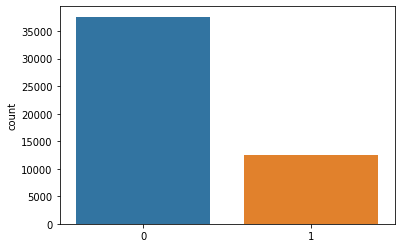

In [96]:
#visualisasi hasil prediksi
sns.countplot(x=result, data = df_pred)

In [97]:
#Hasil prediksi
shipment_predict = len(result)
save_count = len(result[result == 0]) #barang disimpan
return_count = len(result[result == 1]) #barang dikembalikan
save_percentage = round(save_count/shipment_predict*100, 2)
return_percentage = round(return_count/shipment_predict*100, 2)

print('Total shipment {}'.format(shipment_predict))
print('Barang tidak dikembalikan {}'.format(save_count))
print('Barang dikembalikan {}'.format(return_count))
print('Persentase tidak dikembalikan {}%'.format(save_percentage))
print('Persentase dikembalikan {}%'.format(return_percentage))

Total shipment 50078
Barang tidak dikembalikan 37612
Barang dikembalikan 12466
Persentase tidak dikembalikan 75.11%
Persentase dikembalikan 24.89%


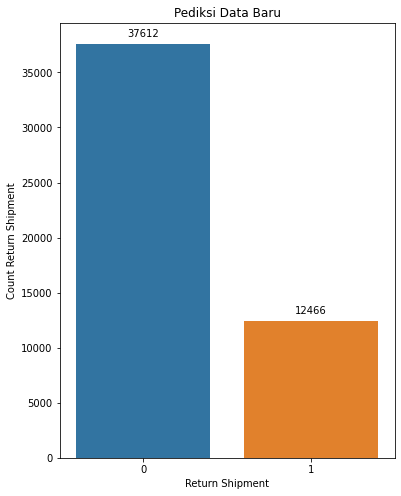

In [98]:
#Visualisasi jumlah data prediksi yang tidak mengembalikan dan mengembalikan 
plt.figure(figsize=(6,8))
ax = sns.countplot(x=result, data = df_pred)
plt.title('Pediksi Data Baru')
plt.xlabel('Return Shipment')
plt.ylabel('Count Return Shipment')

for p in ax.patches:
        ax.annotate(format(p.get_height(), 'd'), (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

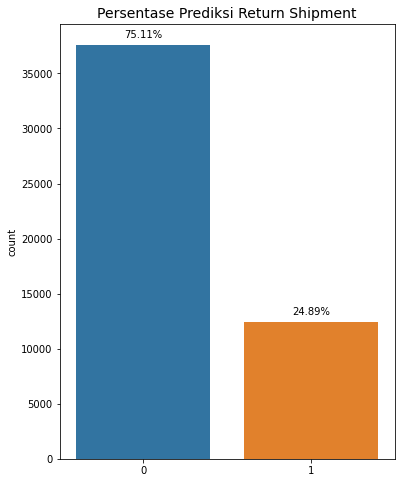

In [99]:
#Visualisasi persentase data prediksi yang tidak mengembalikan dan mengembalikan 
plt.figure(figsize=(6,8))
total = float(len(df_pred))
ax = sns.countplot(x=result, data=df_pred)
plt.title('Persentase Prediksi Return Shipment', fontsize=14)

for p in ax.patches:
        ax.annotate(format(100 * p.get_height()/total, '.2f') + '%', (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

*Dari hasil prediksi di atas yang memprediksi apakah ada pengembalian barang pada pembelian berdasarkan data pembelian baru toko tersebut.
Terdapat pengembalian barang tetapi lebih banyak yang tidak mengembalikan barang, di mana sebanyak 75.11$ tidak mengembalikan pesanan sedangkan sebanyak 24.89% mengembalikan barang.*